In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import janitor
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [3]:
import src.modeling.simulation_based_calibration_helpers as sbc
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.io import cache_io
from src.loggers import logger
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.models.speclet_six import SpecletSix
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor
from src.project_enums import ModelFitMethod

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 300
np.random.seed(RANDOM_SEED)

HDI_PROB = 0.89

In [5]:
sp6 = SpecletSix("expt-sbc", cache_io.default_cache_dir(), debug=True)

In [6]:
if False:
    sp6.cache_manager.clear_all_caches()
    sp6._reset_model_and_results()

sp6.cache_manager.mcmc_cache_exists()

[06/15/21 15:19:46] WARNING  Reseting all model and results.             ]8;id=1623784786.1171877-777651;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:144

False

In [7]:
sbc_dir = results_path = sp6.cache_manager.cache_dir / "sbc"

In [8]:
sp6.run_simulation_based_calibration(
    sbc_dir,
    fit_method=ModelFitMethod.mcmc,
    random_seed=RANDOM_SEED,
    size="medium",
    fit_kwargs={
        "mcmc_draws": 1000,
        "tune": 1500,
        "chains": 4,
        "cores": 4,
        "target_accept": 0.99,
        "prior_pred_samples": 1000,
        "post_pred_samples": 1000,
    },
)

[06/15/21 15:20:08] INFO     Generating mock data of size          ]8;id=1623784808.2601676-335093;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:305
                             'medium'.

                    INFO     Applying 6 data transformations.      ]8;id=1623784808.5132124-328462;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:129

                    INFO     Applying transformation: '_drop_sgrna ]8;id=1623784808.516593-39785;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             s_that_map_to_multiple_genes'

                    WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1623784808.539825-580563;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:249
                             genes.

                    INFO     Applying transformation:              ]8;id=1623784808.54912-262753;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             '_drop_missing_copynumber'

                    WARNING  Dropping 0 data points with missing   ]8;id=1623784808.5580337-861325;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:259
                             copy number.

                    INFO     Applying transformation:              ]8;id=1623784808.56261-68473;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             'centered_copynumber_by_cellline'

                    INFO     Adding 'copy_number_cellline' column.          ]8;id=1623784808.5690556-76730;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:26

                    INFO     Applying transformation:              ]8;id=1623784808.5897791-249679;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             'centered_copynumber_by_gene'

                    INFO     Adding 'copy_number_gene' column.              ]8;id=1623784808.5935993-202540;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:44

                    INFO     Applying transformation: 'zscale_rna_ ]8;id=1623784808.6120133-849539;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             expression_by_gene_and_lineage'

                    INFO     Adding 'rna_expr_gene_lineage' column.         ]8;id=1623784808.6155465-427306;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:62

                    INFO     Applying transformation:              ]8;id=1623784808.8591316-970291;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             'convert_is_mutated_to_numeric'

                    INFO     Converting 'is_mutated' column to 'int'.       ]8;id=1623784808.8625808-752939;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:81

                    INFO     Calling `model_specification()` method.     ]8;id=1623784808.8691-759817;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:184

                    INFO     Beginning PyMC3 model specification.          ]8;id=1623784808.8738208-753794;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:271

                    INFO     Getting Theano shared variables.              ]8;id=1623784808.8989205-355885;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:279

                    INFO     Creating PyMC3 SpecletSix model.              ]8;id=1623784808.9073052-625712;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:318

[06/15/21 15:20:23] INFO     Found 2 cell line lineages.                   ]8;id=1623784823.5056233-498675;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:357

[06/15/21 15:20:28] INFO     Applying 6 data transformations.      ]8;id=1623784828.333385-766554;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:129

                    INFO     Applying transformation: '_drop_sgrna ]8;id=1623784828.3374097-453209;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             s_that_map_to_multiple_genes'

                    WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1623784828.3507824-249372;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:249
                             genes.

                    INFO     Applying transformation:              ]8;id=1623784828.357175-726067;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             '_drop_missing_copynumber'

                    WARNING  Dropping 0 data points with missing   ]8;id=1623784828.3623762-988127;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:259
                             copy number.

                    INFO     Applying transformation:              ]8;id=1623784828.3653793-186427;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             'centered_copynumber_by_cellline'

                    INFO     Adding 'copy_number_cellline' column.          ]8;id=1623784828.3682482-960976;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:26

                    INFO     Applying transformation:              ]8;id=1623784828.3835351-474357;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             'centered_copynumber_by_gene'

                    INFO     Adding 'copy_number_gene' column.              ]8;id=1623784828.386574-325265;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:44

                    INFO     Applying transformation: 'zscale_rna_ ]8;id=1623784828.4043102-987927;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             expression_by_gene_and_lineage'

                    INFO     Adding 'rna_expr_gene_lineage' column.         ]8;id=1623784828.4071136-10896;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:62

                    INFO     Applying transformation:              ]8;id=1623784828.702513-917015;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:116
                             'convert_is_mutated_to_numeric'

                    INFO     Converting 'is_mutated' column to 'int'.       ]8;id=1623784828.7056196-383595;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:81

                    INFO     Setting new data for observed variable:     ]8;id=1623784828.714211-17451;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:517
                             'lfc_shared'.

                    INFO     Updating the MCMC sampling parameters.        ]8;id=1623784828.7191565-343756;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_six.py\speclet_six.py]8;;\:489

                    INFO     Beginning MCMC sampling.                    ]8;id=1623784828.724437-835125;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:289

/n/data1/hms/dbmi/park/Cook/speclet/src/modeling/pymc3_sampling_api.py:122: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, σ_σ, i, a_offset, σ_a, σ_σ_a, μ_a_offset, σ_μ_a, μ_μ_a, d_offset, σ_d, σ_σ_d, μ_d_offset, σ_μ_d, μ_μ_d, h_offset, σ_h, μ_h, j_offset, σ_j, μ_j_offset, σ_σ_j, σ_μ_j, μ_μ_j]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 2025 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


posterior predictive variable lfc's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


[06/15/21 15:55:19] INFO     Finished MCMC sampling - caching results.   ]8;id=1623786919.270016-384988;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:302

                    INFO     Caching InferenceData to '/n/data1/hms/dbm ]8;id=1623786919.2800074-748005;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:245
                             i/park/Cook/speclet/models/speclet-six_exp                      
                             t-sbc/mcmc/inference-data.nc'.

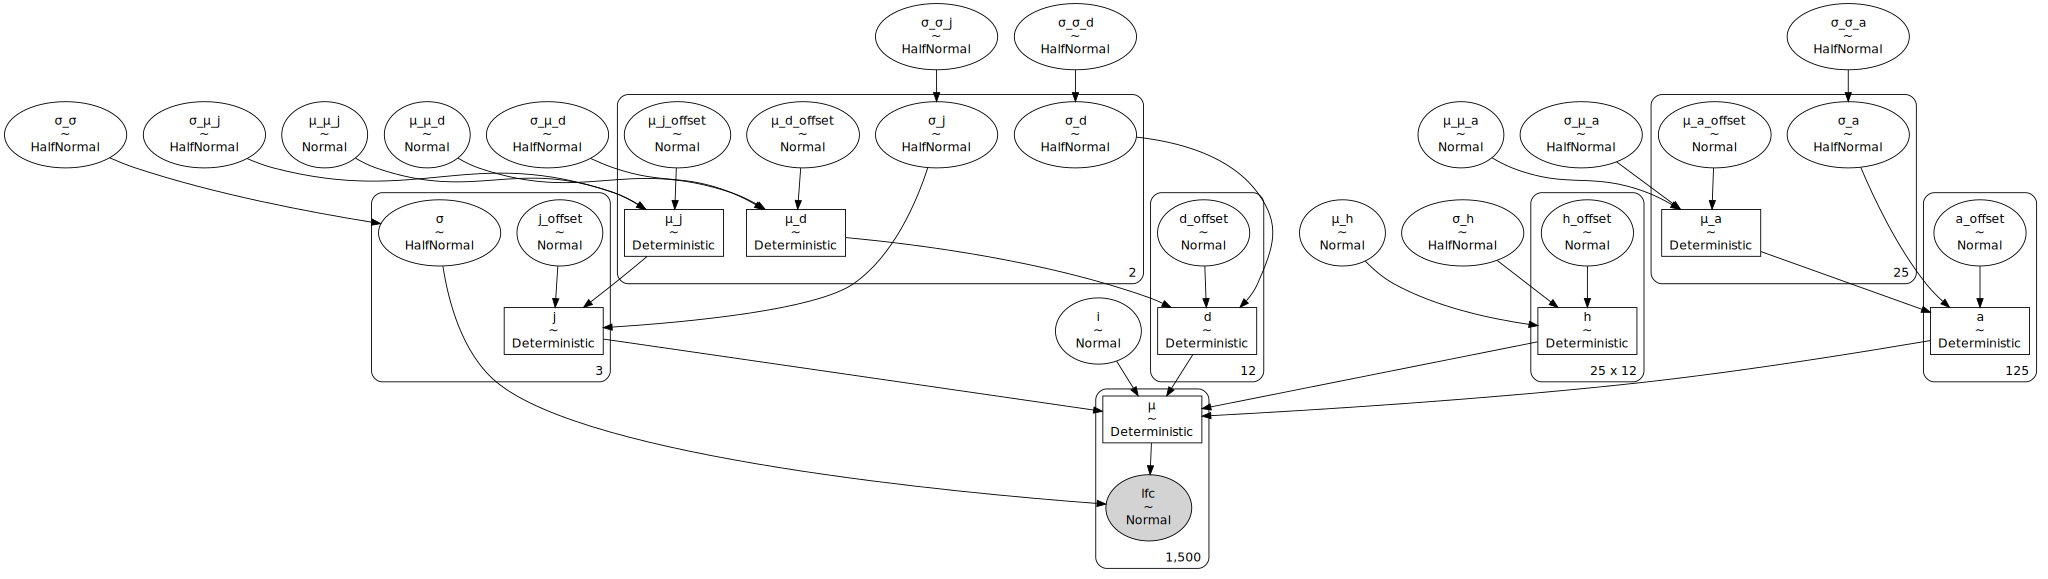

In [9]:
pm.model_to_graphviz(sp6.model)

## Visualization of mock data

In [10]:
mock_data = sp6.data_manager.get_data()
print(mock_data.shape)
mock_data.head()

(1500, 15)


,depmap_id,hugo_symbol,lineage,p_dna_batch,screen,sgrna,copy_number,rna_expr,is_mutated,lfc,copy_number_cellline,copy_number_gene,rna_expr_gene_lineage,copy_number_cellline,copy_number_gene
0,cellline0,gene0,lineage0,batch1,screen1,gene0_sgrna0,0.867120,2.991676,0,-2.518735,-0.135827,-0.171755,-0.220377,-0.135827,-0.171755
1,cellline0,gene0,lineage0,batch1,screen1,gene0_sgrna1,1.031808,2.634558,0,-2.530463,0.028861,-0.007067,-0.515322,0.028861,-0.007067
2,cellline0,gene0,lineage0,batch1,screen1,gene0_sgrna2,1.027714,3.132313,0,-2.708820,0.024767,-0.011160,-0.111409,0.024767,-0.011160
3,cellline0,gene0,lineage0,batch1,screen1,gene0_sgrna3,0.762553,3.190555,0,-2.588274,-0.240393,-0.276321,-0.067365,-0.240393,-0.276321
4,cellline0,gene0,lineage0,batch1,screen1,gene0_sgrna4,0.955970,2.286955,0,-2.609368,-0.046977,-0.082905,-0.831675,-0.046977,-0.082905


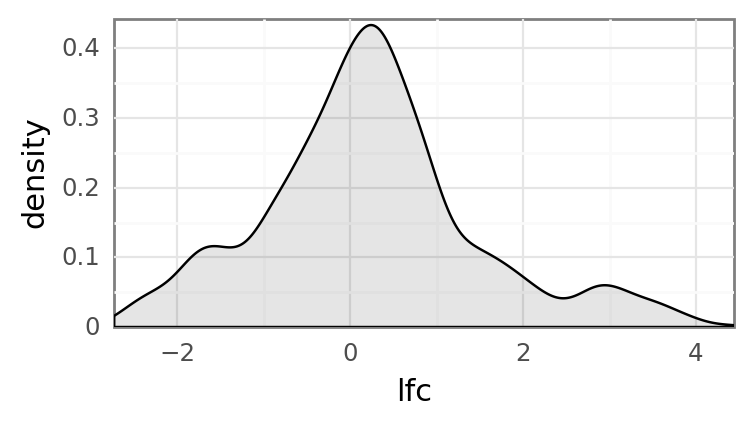

<ggplot: (8738680274752)>

In [11]:
(
    gg.ggplot(mock_data, gg.aes(x="lfc"))
    + gg.geom_density(fill="black", alpha=0.1)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme(figure_size=(4, 2))
)

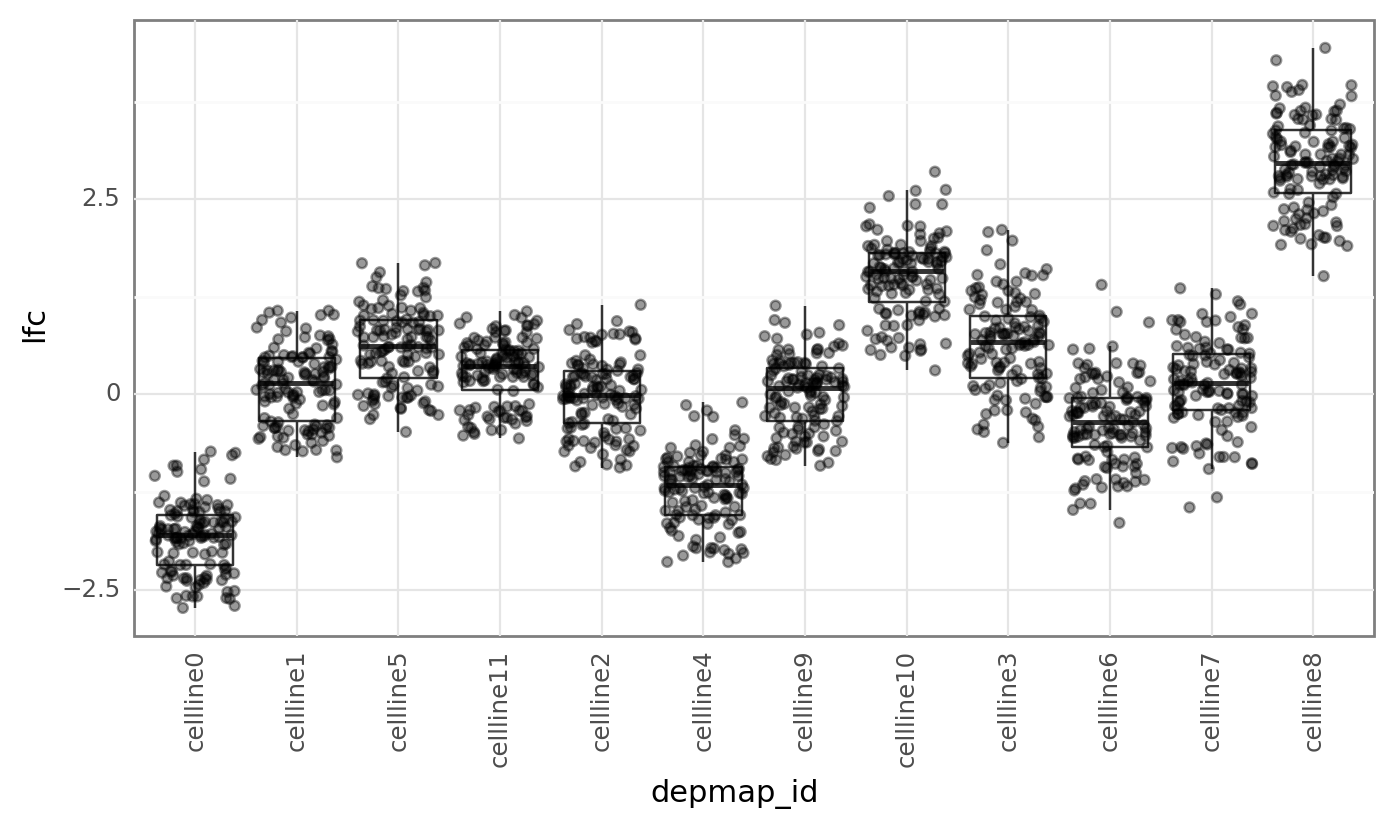

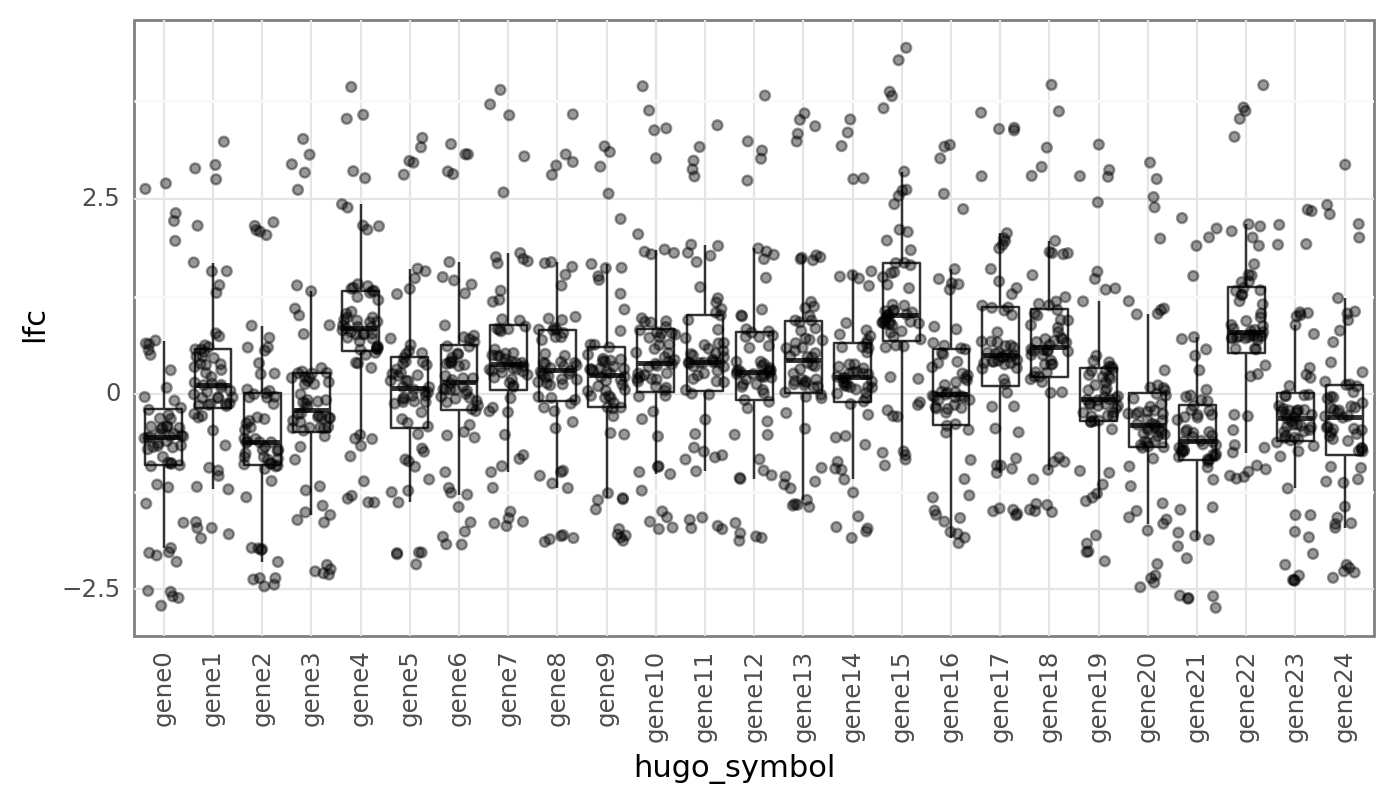

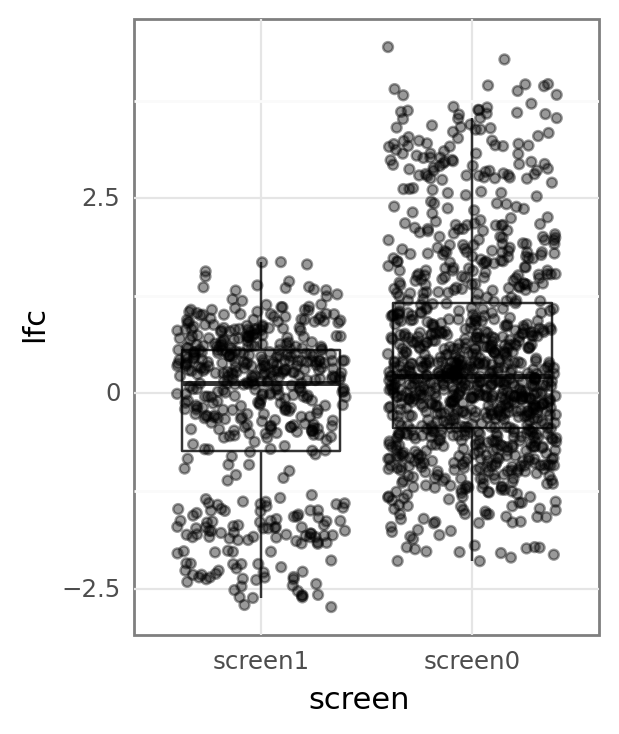

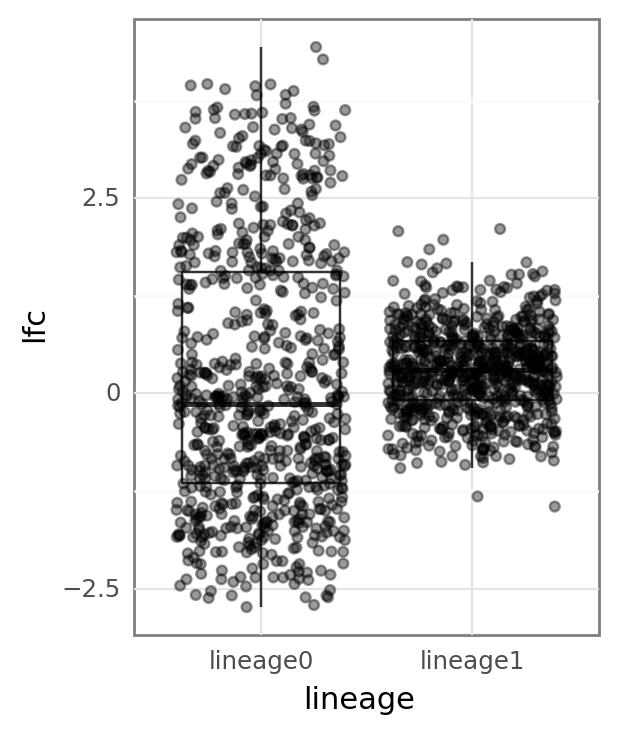

In [12]:
plot_cols = ["depmap_id", "hugo_symbol", "screen", "lineage"]
plot_sizes = [(8, 4), (8, 4), (3, 4), (3, 4)]
text_angles = [90] * 2 + [0] * 2
for col, figure_size, ta in zip(plot_cols, plot_sizes, text_angles):
    (
        gg.ggplot(mock_data, gg.aes(x=col, y="lfc"))
        + gg.geom_boxplot(outlier_alpha=0.0)
        + gg.geom_jitter(alpha=0.4)
        + gg.theme(axis_text_x=gg.element_text(angle=ta), figure_size=figure_size)
    ).draw()

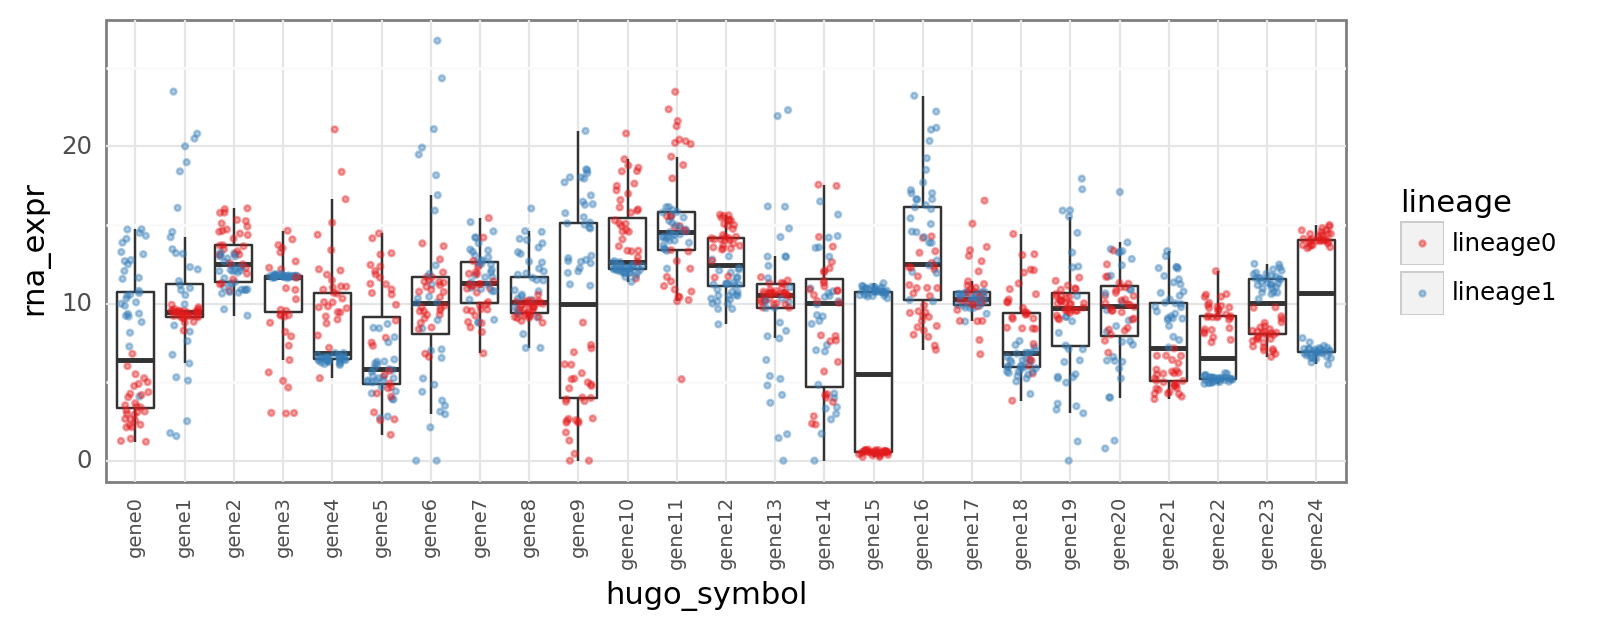

<ggplot: (8738680388386)>

In [13]:
(
    gg.ggplot(mock_data, gg.aes(x="hugo_symbol", y="rna_expr"))
    + gg.geom_boxplot(outlier_alpha=0.0)
    + gg.geom_jitter(gg.aes(color="lineage"), alpha=0.4, size=0.7, width=0.3)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=7), figure_size=(8, 3))
)

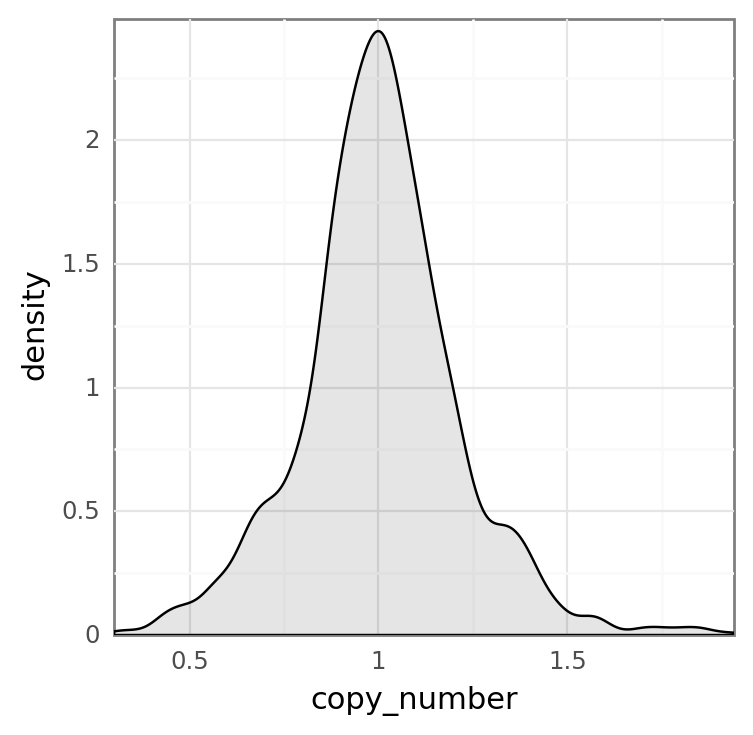

<ggplot: (8738684793619)>

In [14]:
(
    gg.ggplot(mock_data, gg.aes(x="copy_number"))
    + gg.geom_density(fill="black", alpha=0.1)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
)

## Model parameters

In [15]:
sbc_manager = sbc.SBCFileManager(sbc_dir)

if sbc_manager.all_data_exists():
    sbc_res = sbc_manager.get_sbc_results()
else:
    FileNotFoundError("Could not locate SBC results data.")

In [16]:
sbc_res.priors["μ_a"]

array([[-0.19179767, -0.30535879, -0.25074894, -0.16053762, -0.38797575,
        -0.17995121, -0.28435169, -0.2208943 , -0.09097861, -0.32018563,
        -0.34413258,  0.02612957, -0.12667364, -0.23501735, -0.31967583,
        -0.12384697, -0.17069612, -0.2285658 , -0.19717503, -0.27001456,
        -0.21471246, -0.03488678, -0.17438616, -0.22938009, -0.22753789]])

In [17]:
(
    sbc_res.posterior_summary.reset_index(drop=False)
    .filter_string("parameter", "^μ_a\\[")
    .filter_string("parameter", "offset", complement=True)
    .reset_index(drop=True)
    .assign(real_value=sbc_res.priors["μ_a"].flatten())
)

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,real_value
0,μ_a[0],-0.033,0.479,-0.771,0.763,0.048,0.034,102.0,672.0,1.05,-0.191798
1,μ_a[1],0.059,0.478,-0.718,0.801,0.032,0.023,225.0,665.0,1.04,-0.305359
2,μ_a[2],0.171,0.478,-0.602,0.935,0.028,0.020,291.0,650.0,1.03,-0.250749
3,μ_a[3],0.116,0.504,-0.680,0.932,0.054,0.038,91.0,295.0,1.05,-0.160538
4,μ_a[4],-0.061,0.483,-0.835,0.709,0.029,0.021,277.0,659.0,1.02,-0.387976
5,μ_a[5],0.044,0.525,-0.806,0.858,0.030,0.021,322.0,545.0,1.03,-0.179951
6,μ_a[6],0.054,0.505,-0.697,0.864,0.028,0.020,333.0,774.0,1.02,-0.284352
7,μ_a[7],0.063,0.521,-0.823,0.820,0.027,0.019,370.0,727.0,1.02,-0.220894
8,μ_a[8],0.035,0.520,-0.757,0.882,0.026,0.019,397.0,835.0,1.02,-0.090979
9,μ_a[9],0.033,0.522,-0.888,0.783,0.029,0.020,332.0,585.0,1.02,-0.320186


/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:>

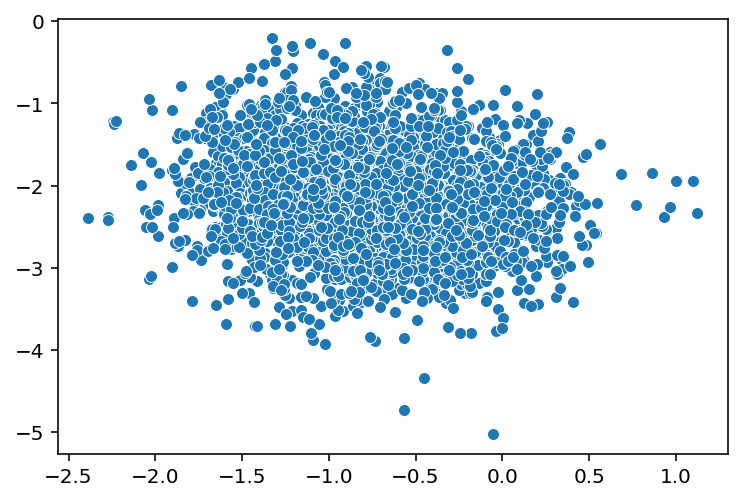

In [18]:
x = sbc_res.inference_obj.posterior["a"][:, :, 0].values.flatten()
y = sbc_res.inference_obj.posterior["d"][:, :, 0].values.flatten()
sns.scatterplot(x, y)

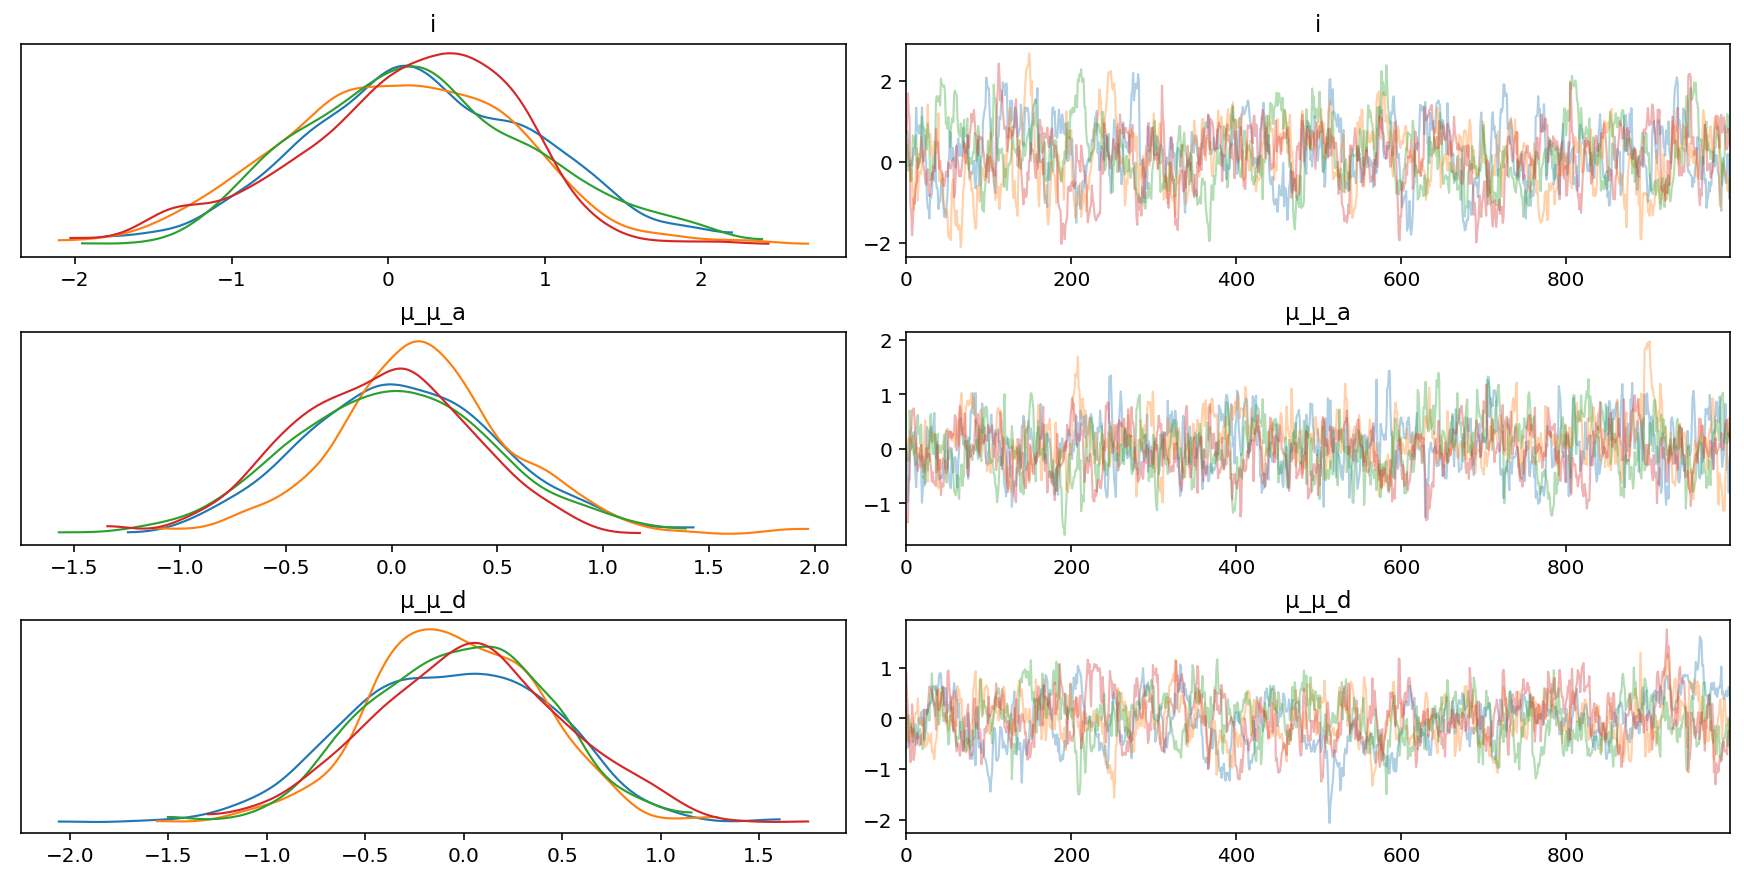

In [21]:
az.plot_trace(sbc_res.inference_obj, var_names=["i", "μ_μ_a", "μ_μ_d"], compact=False);

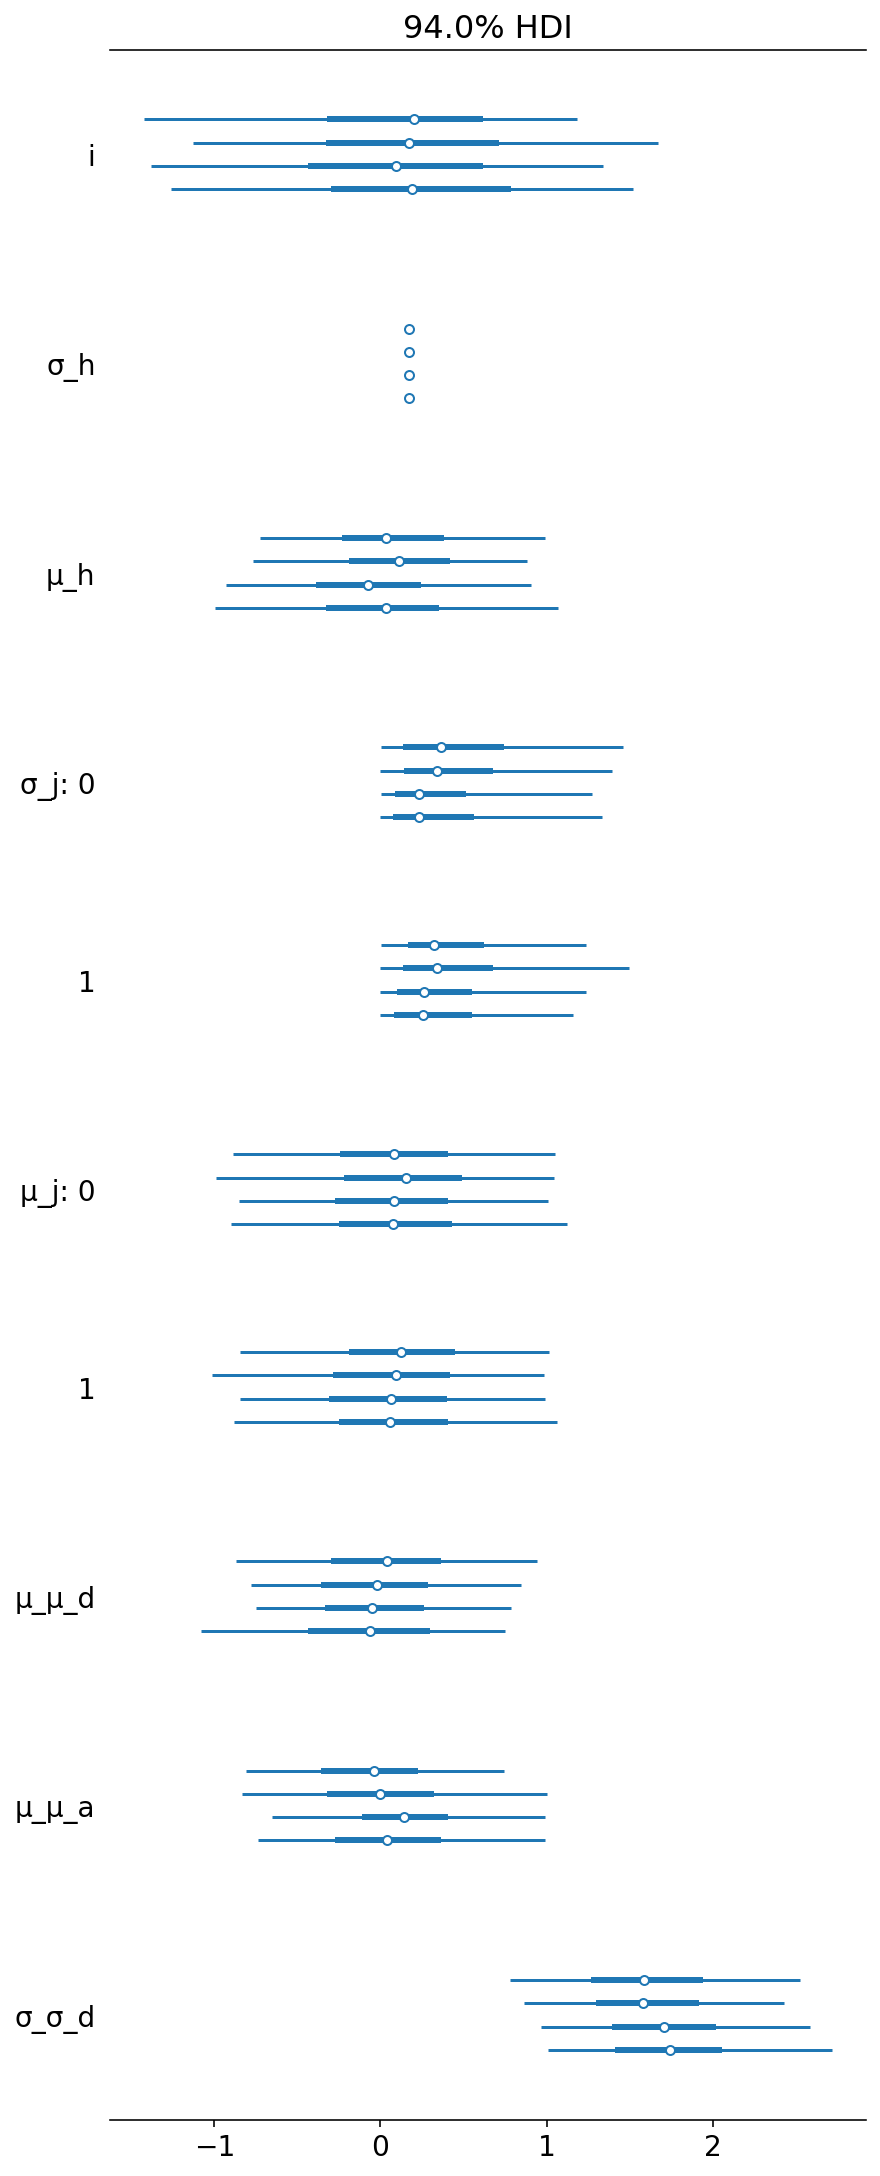

In [22]:
az.plot_forest(
    sbc_res.inference_obj,
    var_names=["i", "σ_h", "μ_h", "σ_j", "μ_j", "μ_μ_d", "μ_μ_a", "σ_σ_d"],
);

In [23]:
az.summary(sbc_res.inference_obj, var_names=["σ_d"], hdi_prob=HDI_PROB).assign(
    real_value=sbc_res.priors["σ_d"].flatten()
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,real_value
σ_d[0],3.090,0.734,1.884,4.093,0.171,0.123,17.0,137.0,1.17,3.612109
σ_d[1],0.732,0.313,0.326,1.096,0.037,0.026,88.0,133.0,1.03,0.416385


In [24]:
genes = mock_data["hugo_symbol"].cat.categories.values
cell_lines = mock_data["depmap_id"].cat.categories.values

In [25]:
h_posterior = (
    sbc_res.posterior_summary.reset_index(drop=False)
    .filter_string("parameter", "h\\[")
    .reset_index(drop=True)
    .pipe(
        pmanal.extract_matrix_variable_indices,
        col="parameter",
        idx1=genes,
        idx2=cell_lines,
        idx1name="hugo_symbol",
        idx2name="depmap_id",
    )
    .assign(real_value=sbc_res.priors["h"].flatten())
    .assign(
        hugo_symbol=lambda d: pd.Categorical(
            d["hugo_symbol"].values, categories=genes, ordered=True
        ),
        depmap_id=lambda d: pd.Categorical(
            d["depmap_id"].values, categories=cell_lines, ordered=True
        ),
    )
)

h_posterior.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,hugo_symbol,depmap_id,real_value
0,"h[0,0]",0.037,0.494,-0.801,0.776,0.028,0.02,303.0,548.0,1.01,gene0,cellline0,-0.217898
1,"h[0,1]",0.170,0.496,-0.682,0.902,0.028,0.02,305.0,553.0,1.01,gene0,cellline1,-0.020496
2,"h[0,2]",-0.011,0.493,-0.853,0.725,0.028,0.02,307.0,595.0,1.01,gene0,cellline5,-0.257137
3,"h[0,3]",0.022,0.493,-0.844,0.733,0.028,0.02,305.0,573.0,1.01,gene0,cellline11,-0.197113
4,"h[0,4]",0.054,0.492,-0.736,0.828,0.028,0.02,305.0,545.0,1.01,gene0,cellline2,-0.271462


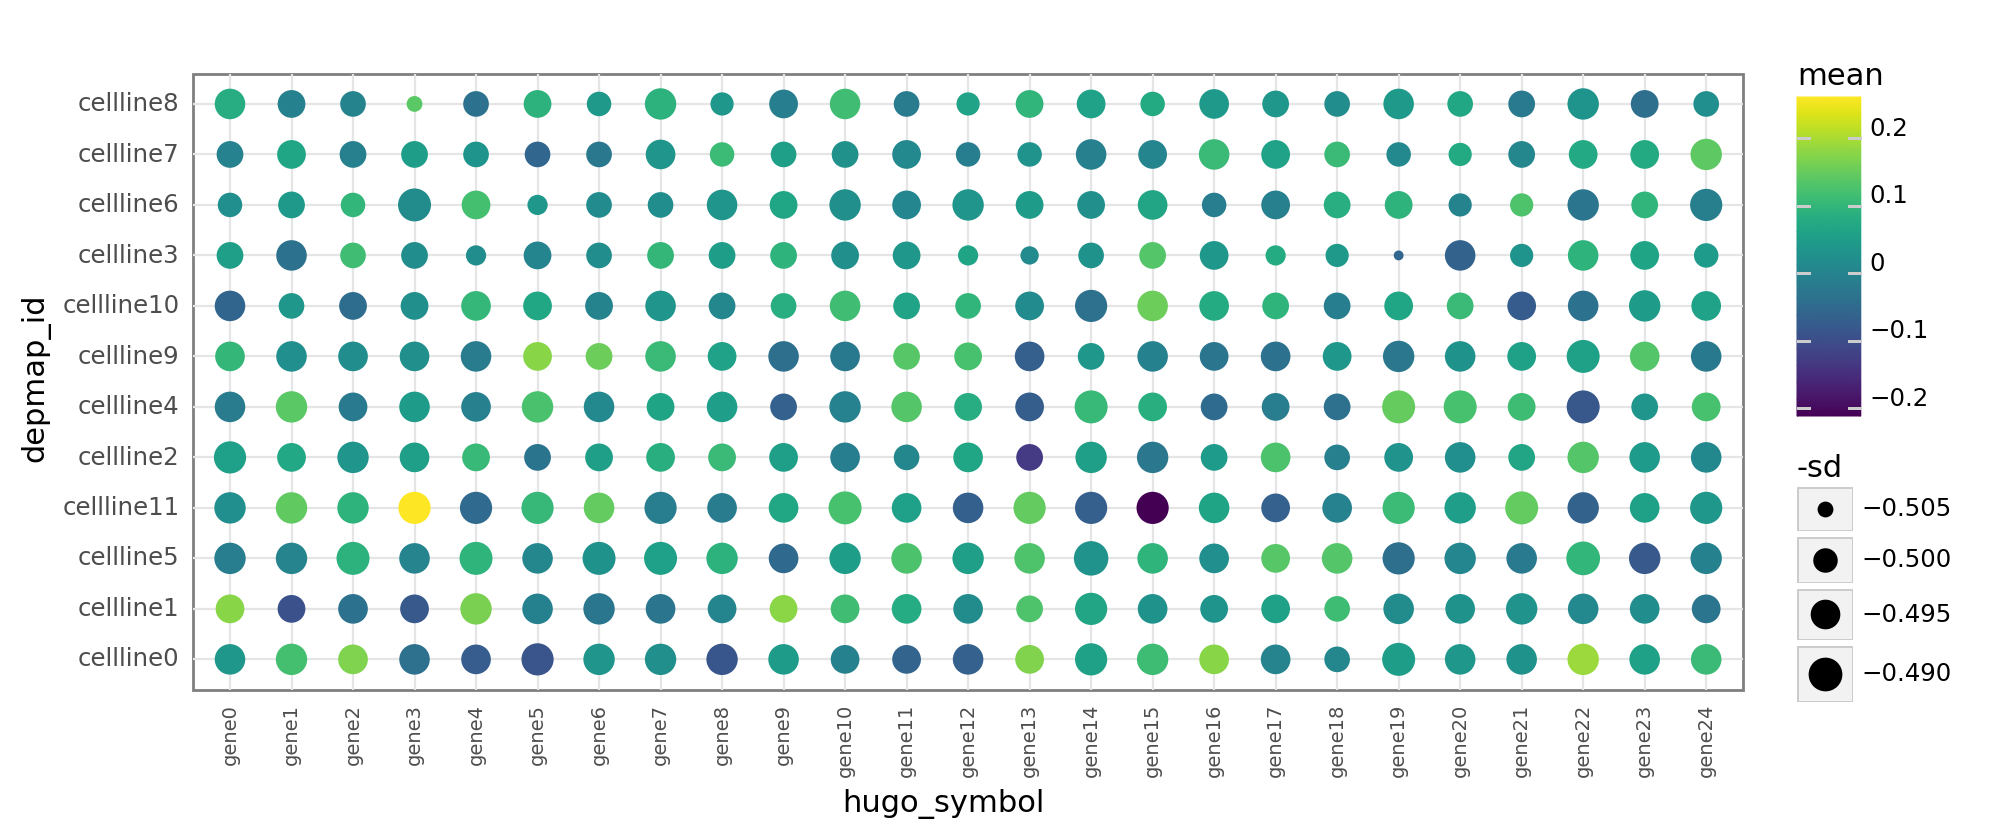

<ggplot: (8738690070797)>

In [26]:
(
    gg.ggplot(h_posterior, gg.aes(x="hugo_symbol", y="depmap_id"))
    + gg.geom_point(gg.aes(color="mean", size="-sd"))
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=7), figure_size=(10, 4))
)

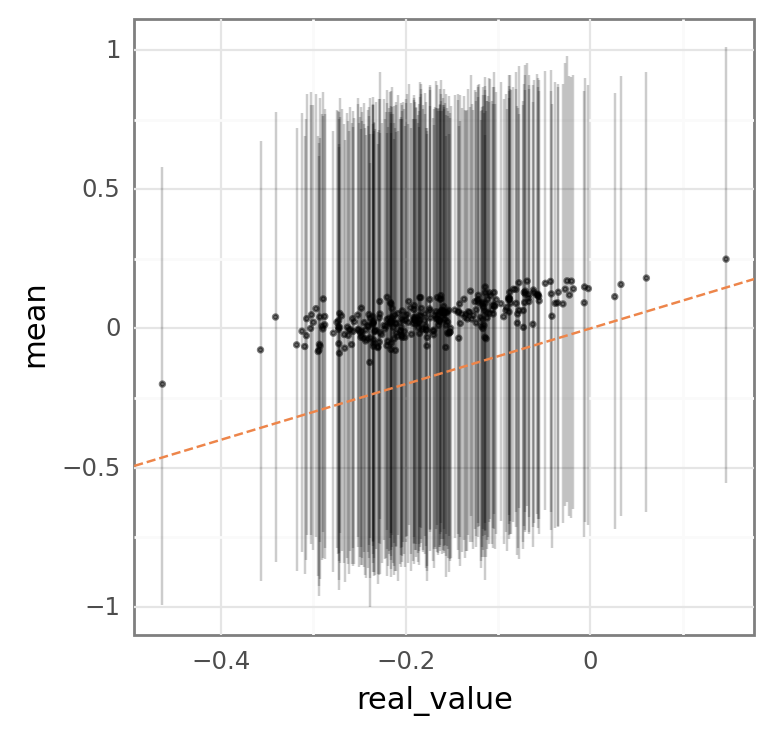

<ggplot: (8738691349995)>

In [27]:
(
    gg.ggplot(h_posterior, gg.aes(x="real_value", y="mean"))
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), alpha=0.2)
    + gg.geom_point(size=0.5, alpha=0.5)
    + gg.geom_abline(slope=1, intercept=0, color=SeabornColor.orange, linetype="--")
)

## Posterior predictions

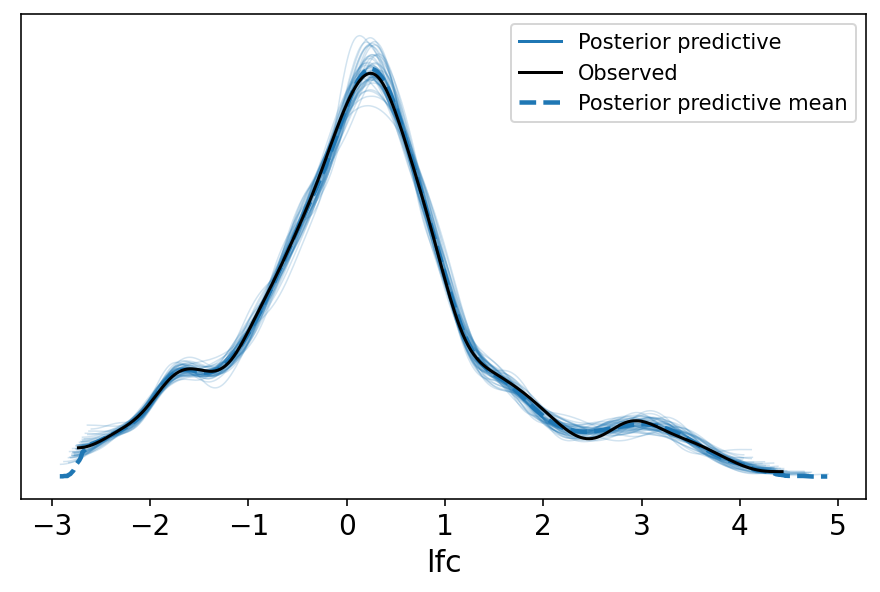

In [28]:
az.plot_ppc(sbc_res.inference_obj, num_pp_samples=50);

In [29]:
sp6_post_pred = pmanal.summarize_posterior_predictions(
    sbc_res.inference_obj.posterior_predictive["lfc"].values.squeeze(),
    merge_with=mock_data,
    calc_error=True,
    observed_y="lfc",
)

sp6_post_pred.head()

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


,pred_mean,pred_hdi_low,pred_hdi_high,depmap_id,hugo_symbol,lineage,p_dna_batch,screen,sgrna,copy_number,rna_expr,is_mutated,lfc,copy_number_cellline,copy_number_gene,rna_expr_gene_lineage,copy_number_cellline,copy_number_gene,error
0,-2.586405,-2.721328,-2.444794,cellline0,gene0,lineage0,batch1,screen1,gene0_sgrna0,0.867120,2.991676,0,-2.518735,-0.135827,-0.171755,-0.220377,-0.135827,-0.171755,0.067670
1,-2.585555,-2.729544,-2.456240,cellline0,gene0,lineage0,batch1,screen1,gene0_sgrna1,1.031808,2.634558,0,-2.530463,0.028861,-0.007067,-0.515322,0.028861,-0.007067,0.055093
2,-2.585257,-2.719169,-2.436424,cellline0,gene0,lineage0,batch1,screen1,gene0_sgrna2,1.027714,3.132313,0,-2.708820,0.024767,-0.011160,-0.111409,0.024767,-0.011160,-0.123563
3,-2.586673,-2.721571,-2.443257,cellline0,gene0,lineage0,batch1,screen1,gene0_sgrna3,0.762553,3.190555,0,-2.588274,-0.240393,-0.276321,-0.067365,-0.240393,-0.276321,-0.001602
4,-2.587533,-2.729328,-2.451326,cellline0,gene0,lineage0,batch1,screen1,gene0_sgrna4,0.955970,2.286955,0,-2.609368,-0.046977,-0.082905,-0.831675,-0.046977,-0.082905,-0.021836


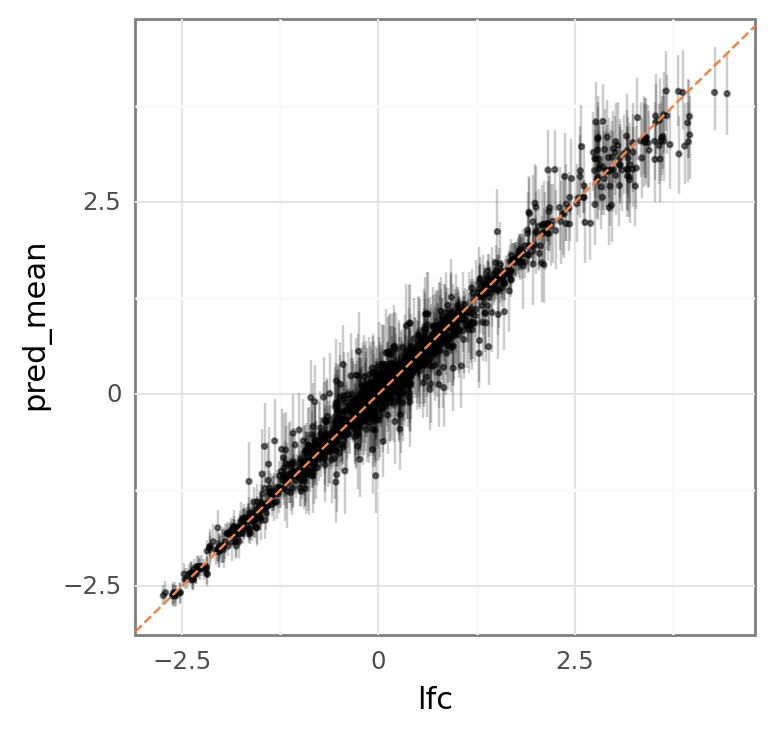

<ggplot: (8738690136727)>

In [30]:
(
    gg.ggplot(sp6_post_pred, gg.aes(x="lfc", y="pred_mean"))
    + gg.geom_linerange(gg.aes(ymin="pred_hdi_low", ymax="pred_hdi_high"), alpha=0.2)
    + gg.geom_point(size=0.5, alpha=0.5)
    + gg.geom_abline(slope=1, intercept=0, color=SeabornColor.orange, linetype="--")
)

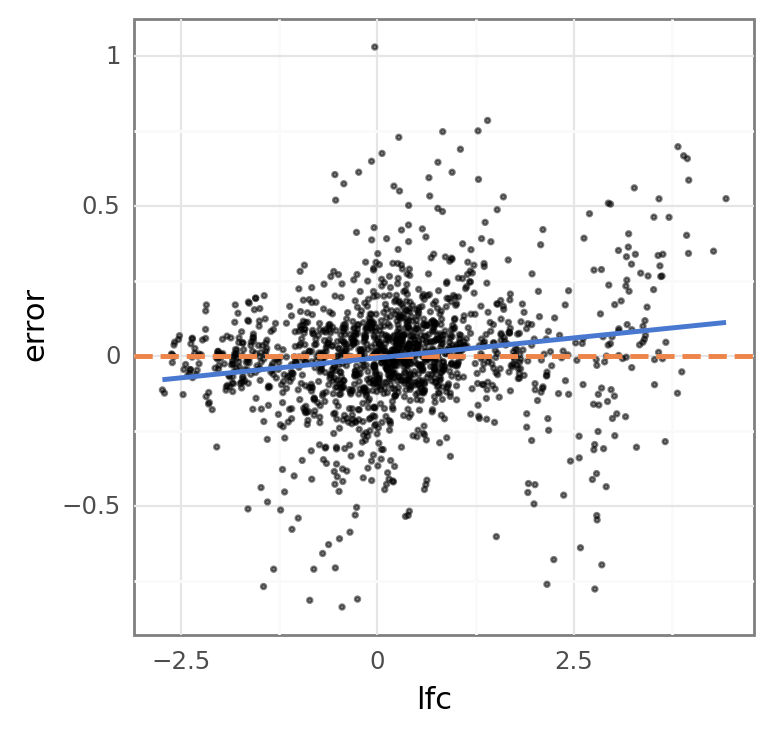

<ggplot: (8738695266994)>

In [31]:
(
    gg.ggplot(sp6_post_pred, gg.aes(x="lfc", y="error"))
    + gg.geom_point(size=0.5, alpha=0.5)
    + gg.geom_hline(yintercept=0, color=SeabornColor.orange, linetype="--", size=1)
    + gg.geom_smooth(
        method="lm", formula="y~x", se=False, color=SeabornColor.blue, size=1
    )
)

---

In [ ]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m